In [2]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
import numpy as np
print( f"NumPy {np.__version__}\n" )
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam
from show_predicted_img import show_predicted_img

TensorFlow 2.13.0
tf.keras.backend.image_data_format() = channels_last
NumPy 1.23.2



In [3]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [4]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
# np.random.seed(1234)
# tf.random.set_seed(5678)

In [5]:
PATH = 'dataset/train/'

In [6]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.


Using 576 files for training.


2023-11-04 13:24:25.524172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-04 13:24:25.524203: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-04 13:24:25.524214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-04 13:24:25.524751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-04 13:24:25.525121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['caribou', 'deer', 'elk', 'moose']


In [7]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [8]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


In [9]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [10]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [11]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-11-04 13:24:29.549737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


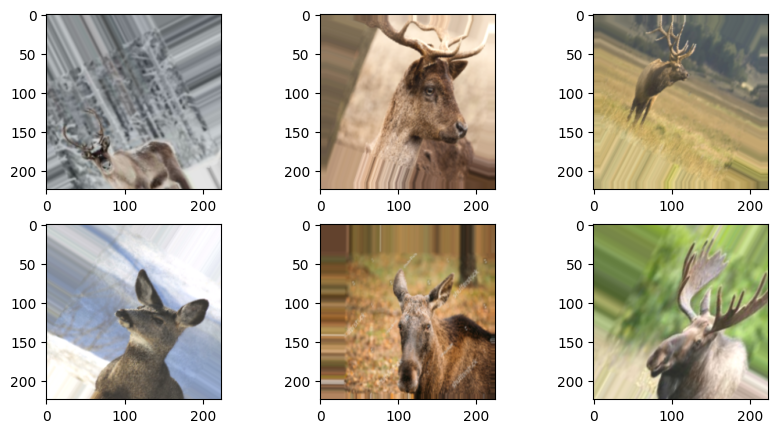

In [12]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [13]:
full_train_ds = train_ds.concatenate(augmented_train)

In [14]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-11-04 13:24:39.222807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1152


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [277]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet"
                         )
base_model.trainable = False
# for layer in base_model.layers:
#     # if layer.name in ['conv5_block3_3_conv']:
#     #     layer.trainable = True
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

In [278]:
# Fine-tune from this layer onwards
start_tune = 528
stop_tune = 561


for layer in base_model.layers[start_tune:stop_tune]:
  layer.trainable = True

# for layer in base_model.layers:
#   if layer.__class__.__name__ in ["BatchNormalization"]:
#     layer.trainable = True

In [279]:
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_14 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_

In [280]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [281]:
# tf.keras.utils.plot_model(base_model, to_file='resnet_feature.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [282]:
base_model_output = base_model.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [283]:
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_14 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_

In [284]:
# Defining Callbacks

checkpoint_filepath = "resnet_callback/bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                option = tf.saved_model.SaveOptions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)
callback_list = [earlystopping, checkpoint,reduce_lr]

In [285]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [286]:
epoch = 80
model_history=model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs = epoch,
                        callbacks = callback_list,
                        verbose = 2)

Epoch 1/80


2023-11-02 16:14:29.250226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:15:15.337786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:15:32.147943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.82161, saving model to resnet_callback/bestmodel_epoch01_valloss1.82.h5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 98s - loss: 1.8523 - accuracy: 0.4514 - val_loss: 1.8216 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 98s/epoch - 3s/step
Epoch 2/80


2023-11-02 16:16:08.005554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 1.82161 to 0.77948, saving model to resnet_callback/bestmodel_epoch02_valloss0.78.h5
36/36 - 23s - loss: 1.3093 - accuracy: 0.5920 - val_loss: 0.7795 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 23s/epoch - 637ms/step
Epoch 3/80


2023-11-02 16:16:30.969134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss improved from 0.77948 to 0.69720, saving model to resnet_callback/bestmodel_epoch03_valloss0.70.h5
36/36 - 23s - loss: 1.0743 - accuracy: 0.6571 - val_loss: 0.6972 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 23s/epoch - 633ms/step
Epoch 4/80


2023-11-02 16:16:53.766996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss improved from 0.69720 to 0.36788, saving model to resnet_callback/bestmodel_epoch04_valloss0.37.h5
36/36 - 22s - loss: 0.9907 - accuracy: 0.6467 - val_loss: 0.3679 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 22s/epoch - 606ms/step
Epoch 5/80


2023-11-02 16:17:15.529404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss did not improve from 0.36788
36/36 - 20s - loss: 0.9366 - accuracy: 0.6493 - val_loss: 0.4226 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 20s/epoch - 562ms/step
Epoch 6/80


2023-11-02 16:17:35.801764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: val_loss improved from 0.36788 to 0.35038, saving model to resnet_callback/bestmodel_epoch06_valloss0.35.h5
36/36 - 21s - loss: 0.9164 - accuracy: 0.6675 - val_loss: 0.3504 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 594ms/step
Epoch 7/80


2023-11-02 16:17:57.283626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 7: val_loss did not improve from 0.35038
36/36 - 19s - loss: 0.8543 - accuracy: 0.6832 - val_loss: 0.3695 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 540ms/step
Epoch 8/80


2023-11-02 16:18:16.607286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 8: val_loss did not improve from 0.35038
36/36 - 19s - loss: 0.8400 - accuracy: 0.6580 - val_loss: 0.3635 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 533ms/step
Epoch 9/80


2023-11-02 16:18:35.671573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 9: val_loss improved from 0.35038 to 0.33164, saving model to resnet_callback/bestmodel_epoch09_valloss0.33.h5
36/36 - 22s - loss: 0.8932 - accuracy: 0.6432 - val_loss: 0.3316 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 22s/epoch - 613ms/step
Epoch 10/80


2023-11-02 16:18:58.132506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 10: val_loss did not improve from 0.33164
36/36 - 19s - loss: 0.8118 - accuracy: 0.6727 - val_loss: 0.3530 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 538ms/step
Epoch 11/80


2023-11-02 16:19:17.258736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 11: val_loss improved from 0.33164 to 0.32416, saving model to resnet_callback/bestmodel_epoch11_valloss0.32.h5
36/36 - 22s - loss: 0.7932 - accuracy: 0.6892 - val_loss: 0.3242 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 22s/epoch - 600ms/step
Epoch 12/80


2023-11-02 16:19:39.060889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 12: val_loss did not improve from 0.32416
36/36 - 19s - loss: 0.7747 - accuracy: 0.6667 - val_loss: 0.3806 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 539ms/step
Epoch 13/80


2023-11-02 16:19:58.280673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 13: val_loss did not improve from 0.32416
36/36 - 20s - loss: 0.7411 - accuracy: 0.7057 - val_loss: 0.3755 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 20s/epoch - 548ms/step
Epoch 14/80


2023-11-02 16:20:18.452980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 14: val_loss did not improve from 0.32416
36/36 - 20s - loss: 0.7562 - accuracy: 0.6944 - val_loss: 0.4205 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 20s/epoch - 551ms/step
Epoch 15/80


2023-11-02 16:20:38.339086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: val_loss did not improve from 0.32416
36/36 - 20s - loss: 0.7332 - accuracy: 0.6944 - val_loss: 0.3811 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 20s/epoch - 557ms/step
Epoch 16/80


2023-11-02 16:20:58.689277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 16: val_loss did not improve from 0.32416
36/36 - 20s - loss: 0.7497 - accuracy: 0.6858 - val_loss: 0.4136 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 20s/epoch - 565ms/step
Epoch 17/80


2023-11-02 16:21:19.206851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_loss did not improve from 0.32416
36/36 - 21s - loss: 0.6987 - accuracy: 0.7040 - val_loss: 0.4069 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 21s/epoch - 572ms/step
Epoch 18/80


2023-11-02 16:21:39.701112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 18: val_loss did not improve from 0.32416
36/36 - 20s - loss: 0.7357 - accuracy: 0.6997 - val_loss: 0.3652 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 20s/epoch - 555ms/step
Epoch 19/80


2023-11-02 16:21:59.376497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 19: val_loss did not improve from 0.32416
36/36 - 19s - loss: 0.7502 - accuracy: 0.6936 - val_loss: 0.3705 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 541ms/step
Epoch 20/80


2023-11-02 16:22:18.850842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 20: val_loss did not improve from 0.32416
36/36 - 19s - loss: 0.7086 - accuracy: 0.7040 - val_loss: 0.3361 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 536ms/step
Epoch 21/80


2023-11-02 16:22:38.050507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 21: val_loss did not improve from 0.32416
36/36 - 19s - loss: 0.7077 - accuracy: 0.6936 - val_loss: 0.3720 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 542ms/step
Epoch 22/80


2023-11-02 16:22:57.460401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 22: val_loss improved from 0.32416 to 0.31865, saving model to resnet_callback/bestmodel_epoch22_valloss0.32.h5
36/36 - 22s - loss: 0.6929 - accuracy: 0.6997 - val_loss: 0.3187 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 22s/epoch - 603ms/step
Epoch 23/80


2023-11-02 16:23:19.545703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 23: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6670 - accuracy: 0.7179 - val_loss: 0.3430 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 539ms/step
Epoch 24/80


2023-11-02 16:23:38.812044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 24: val_loss did not improve from 0.31865
36/36 - 20s - loss: 0.6899 - accuracy: 0.7144 - val_loss: 0.3217 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 20s/epoch - 554ms/step
Epoch 25/80


2023-11-02 16:23:58.645813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 25: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6512 - accuracy: 0.7222 - val_loss: 0.3914 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 538ms/step
Epoch 26/80


2023-11-02 16:24:18.056197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 26: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6826 - accuracy: 0.7135 - val_loss: 0.3714 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 533ms/step
Epoch 27/80


2023-11-02 16:24:37.243834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 27: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6865 - accuracy: 0.7135 - val_loss: 0.3859 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 19s/epoch - 536ms/step
Epoch 28/80


2023-11-02 16:24:56.576811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 28: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6657 - accuracy: 0.7101 - val_loss: 0.3880 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 538ms/step
Epoch 29/80


2023-11-02 16:25:16.469905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 29: val_loss did not improve from 0.31865
36/36 - 20s - loss: 0.6443 - accuracy: 0.7188 - val_loss: 0.3548 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 20s/epoch - 549ms/step
Epoch 30/80


2023-11-02 16:25:35.957056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 30: val_loss did not improve from 0.31865
36/36 - 20s - loss: 0.6339 - accuracy: 0.7318 - val_loss: 0.3438 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 20s/epoch - 544ms/step
Epoch 31/80


2023-11-02 16:25:55.369468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 31: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6535 - accuracy: 0.7127 - val_loss: 0.3693 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 534ms/step
Epoch 32/80


2023-11-02 16:26:14.822706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 32: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6230 - accuracy: 0.7370 - val_loss: 0.3639 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 535ms/step
Epoch 33/80


2023-11-02 16:26:33.998919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 33: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6384 - accuracy: 0.7309 - val_loss: 0.3456 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 533ms/step
Epoch 34/80


2023-11-02 16:26:53.211325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 34: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6229 - accuracy: 0.7396 - val_loss: 0.3534 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 534ms/step
Epoch 35/80


2023-11-02 16:27:12.441291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 35: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6125 - accuracy: 0.7396 - val_loss: 0.3773 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 19s/epoch - 538ms/step
Epoch 36/80


2023-11-02 16:27:31.733807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 36: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6155 - accuracy: 0.7274 - val_loss: 0.3413 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 540ms/step
Epoch 37/80


2023-11-02 16:27:51.277668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 37: val_loss did not improve from 0.31865
36/36 - 20s - loss: 0.6056 - accuracy: 0.7448 - val_loss: 0.3326 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 20s/epoch - 544ms/step
Epoch 38/80


2023-11-02 16:28:10.846724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 38: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6577 - accuracy: 0.7370 - val_loss: 0.3939 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 539ms/step
Epoch 39/80


2023-11-02 16:28:30.404738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 39: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.6295 - accuracy: 0.7352 - val_loss: 0.4132 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 534ms/step
Epoch 40/80


2023-11-02 16:28:49.689605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 40: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.5810 - accuracy: 0.7517 - val_loss: 0.4124 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 534ms/step
Epoch 41/80


2023-11-02 16:29:08.969468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 41: val_loss did not improve from 0.31865
36/36 - 19s - loss: 0.5852 - accuracy: 0.7431 - val_loss: 0.3710 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 536ms/step
Epoch 42/80


2023-11-02 16:29:28.268367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 42: val_loss did not improve from 0.31865

Epoch 42: ReduceLROnPlateau reducing learning rate to 5e-05.
36/36 - 19s - loss: 0.6145 - accuracy: 0.7335 - val_loss: 0.3741 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 19s/epoch - 535ms/step
Epoch 43/80


2023-11-02 16:29:47.882061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 43: val_loss did not improve from 0.31865
36/36 - 20s - loss: 0.5766 - accuracy: 0.7630 - val_loss: 0.3398 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 20s/epoch - 548ms/step
Epoch 44/80


2023-11-02 16:30:07.188892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 44: val_loss improved from 0.31865 to 0.31817, saving model to resnet_callback/bestmodel_epoch44_valloss0.32.h5
36/36 - 21s - loss: 0.5839 - accuracy: 0.7535 - val_loss: 0.3182 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 21s/epoch - 587ms/step
Epoch 45/80


2023-11-02 16:30:28.720759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 45: val_loss did not improve from 0.31817
36/36 - 19s - loss: 0.5438 - accuracy: 0.7717 - val_loss: 0.3293 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 19s/epoch - 541ms/step
Epoch 46/80


2023-11-02 16:30:48.202339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 46: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5748 - accuracy: 0.7648 - val_loss: 0.3528 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 542ms/step
Epoch 47/80


2023-11-02 16:31:07.436343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 47: val_loss did not improve from 0.31817
36/36 - 19s - loss: 0.5447 - accuracy: 0.7682 - val_loss: 0.3907 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 19s/epoch - 535ms/step
Epoch 48/80


2023-11-02 16:31:27.028693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 48: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5386 - accuracy: 0.7778 - val_loss: 0.4055 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 20s/epoch - 549ms/step
Epoch 49/80


2023-11-02 16:31:46.831736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 49: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5392 - accuracy: 0.7691 - val_loss: 0.3852 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 549ms/step
Epoch 50/80


2023-11-02 16:32:06.855736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 50: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5242 - accuracy: 0.7752 - val_loss: 0.3839 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 563ms/step
Epoch 51/80


2023-11-02 16:32:26.782526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 51: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5537 - accuracy: 0.7682 - val_loss: 0.3733 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 545ms/step
Epoch 52/80


2023-11-02 16:32:46.586109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 52: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5318 - accuracy: 0.7821 - val_loss: 0.3603 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 20s/epoch - 545ms/step
Epoch 53/80


2023-11-02 16:33:05.979551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 53: val_loss did not improve from 0.31817
36/36 - 19s - loss: 0.5296 - accuracy: 0.7752 - val_loss: 0.3783 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 534ms/step
Epoch 54/80


2023-11-02 16:33:25.280537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 54: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5387 - accuracy: 0.7743 - val_loss: 0.3804 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 551ms/step
Epoch 55/80


2023-11-02 16:33:45.786993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 55: val_loss did not improve from 0.31817
36/36 - 21s - loss: 0.5603 - accuracy: 0.7569 - val_loss: 0.3774 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 21s/epoch - 574ms/step
Epoch 56/80


2023-11-02 16:34:06.092159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 56: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5237 - accuracy: 0.7804 - val_loss: 0.3369 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 20s/epoch - 547ms/step
Epoch 57/80


2023-11-02 16:34:26.027902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 57: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5264 - accuracy: 0.7752 - val_loss: 0.3421 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 548ms/step
Epoch 58/80


2023-11-02 16:34:45.585882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 58: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5092 - accuracy: 0.7778 - val_loss: 0.3293 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 20s/epoch - 550ms/step
Epoch 59/80


2023-11-02 16:35:05.463220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 59: val_loss did not improve from 0.31817
36/36 - 20s - loss: 0.5091 - accuracy: 0.7847 - val_loss: 0.3286 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 20s/epoch - 547ms/step
Epoch 60/80


2023-11-02 16:35:25.165808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 60: val_loss improved from 0.31817 to 0.30759, saving model to resnet_callback/bestmodel_epoch60_valloss0.31.h5
36/36 - 23s - loss: 0.5340 - accuracy: 0.7804 - val_loss: 0.3076 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 23s/epoch - 639ms/step
Epoch 61/80


2023-11-02 16:35:48.175807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 61: val_loss did not improve from 0.30759
36/36 - 19s - loss: 0.5168 - accuracy: 0.7821 - val_loss: 0.3273 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 540ms/step
Epoch 62/80


2023-11-02 16:36:07.452401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 62: val_loss did not improve from 0.30759
36/36 - 20s - loss: 0.5036 - accuracy: 0.7873 - val_loss: 0.3424 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 549ms/step
Epoch 63/80


2023-11-02 16:36:27.250002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 63: val_loss improved from 0.30759 to 0.29311, saving model to resnet_callback/bestmodel_epoch63_valloss0.29.h5
36/36 - 22s - loss: 0.5130 - accuracy: 0.7865 - val_loss: 0.2931 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 22s/epoch - 614ms/step
Epoch 64/80


2023-11-02 16:36:49.893047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 64: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.5135 - accuracy: 0.7847 - val_loss: 0.3107 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 562ms/step
Epoch 65/80


2023-11-02 16:37:09.800044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 65: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.5200 - accuracy: 0.7865 - val_loss: 0.3122 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 542ms/step
Epoch 66/80


2023-11-02 16:37:29.159975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 66: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.5173 - accuracy: 0.7856 - val_loss: 0.3415 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 541ms/step
Epoch 67/80


2023-11-02 16:37:48.668693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 67: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.4925 - accuracy: 0.8012 - val_loss: 0.3293 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 562ms/step
Epoch 68/80


2023-11-02 16:38:09.450182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 68: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.5047 - accuracy: 0.7917 - val_loss: 0.3862 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 564ms/step
Epoch 69/80


2023-11-02 16:38:29.393327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 69: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.4997 - accuracy: 0.7812 - val_loss: 0.3763 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 544ms/step
Epoch 70/80


2023-11-02 16:38:48.971517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 70: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4888 - accuracy: 0.8038 - val_loss: 0.3543 - val_accuracy: 0.8906 - lr: 5.0000e-05 - 19s/epoch - 536ms/step
Epoch 71/80


2023-11-02 16:39:08.361312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 71: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.4834 - accuracy: 0.7925 - val_loss: 0.3314 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 20s/epoch - 545ms/step
Epoch 72/80


2023-11-02 16:39:27.884477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 72: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4715 - accuracy: 0.8038 - val_loss: 0.3374 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 19s/epoch - 534ms/step
Epoch 73/80


2023-11-02 16:39:47.129088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 73: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4861 - accuracy: 0.7977 - val_loss: 0.3223 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 19s/epoch - 533ms/step
Epoch 74/80


2023-11-02 16:40:06.232566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 74: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4679 - accuracy: 0.8151 - val_loss: 0.3498 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 537ms/step
Epoch 75/80


2023-11-02 16:40:25.751014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 75: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4750 - accuracy: 0.7960 - val_loss: 0.3599 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 535ms/step
Epoch 76/80


2023-11-02 16:40:44.941215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 76: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4879 - accuracy: 0.8012 - val_loss: 0.3919 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 19s/epoch - 530ms/step
Epoch 77/80


2023-11-02 16:41:03.945998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 77: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4594 - accuracy: 0.8168 - val_loss: 0.4047 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 19s/epoch - 530ms/step
Epoch 78/80


2023-11-02 16:41:23.184000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 78: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4870 - accuracy: 0.8116 - val_loss: 0.3753 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 19s/epoch - 541ms/step
Epoch 79/80


2023-11-02 16:41:42.652227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 79: val_loss did not improve from 0.29311
36/36 - 20s - loss: 0.4977 - accuracy: 0.7995 - val_loss: 0.3844 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 20s/epoch - 543ms/step
Epoch 80/80


2023-11-02 16:42:02.148504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 80: val_loss did not improve from 0.29311
36/36 - 19s - loss: 0.4702 - accuracy: 0.8021 - val_loss: 0.3513 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 19s/epoch - 534ms/step


In [287]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

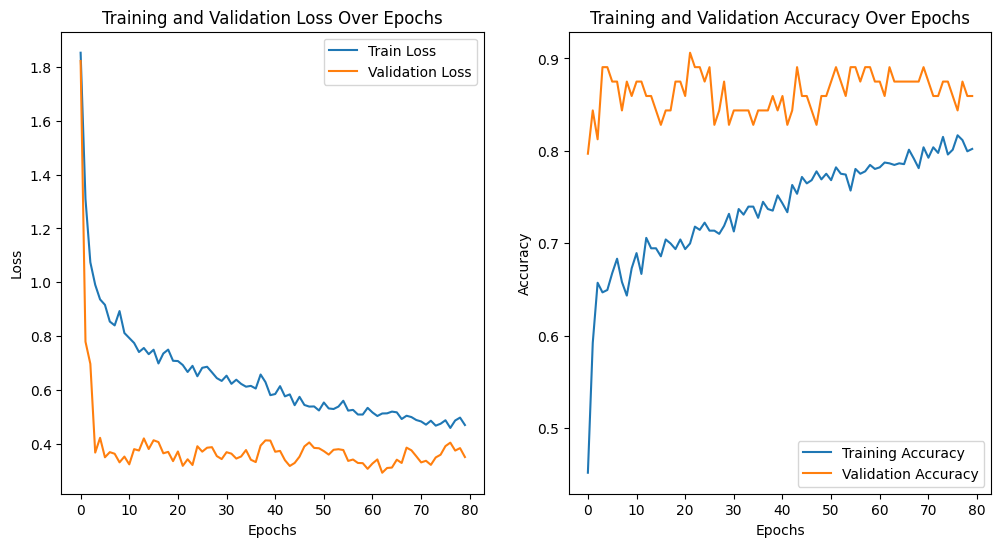

In [288]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [289]:
test_result = model.evaluate(test_dataset)
print(f'{model.metrics_names}: {test_result}')

5/5 [==============================] - 3s 331ms/step - loss: 0.3500 - accuracy: 0.8938
['loss', 'accuracy']: [0.34999600052833557, 0.893750011920929]


In [290]:
model_path = "resnet_callback/train_conv5_block_3_bestmodel_nopool_epoch30_valloss0.22.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-02 16:42:33.089505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 36s 704ms/step - loss: 0.3187 - accuracy: 0.9000
['loss', 'accuracy']: [0.31869131326675415, 0.8999999761581421]


In [291]:
model_path = "resnet_callback/train_conv5_block_3_bestmodel_nopool_epoch25_valloss0.23.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-02 16:43:15.167194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 36s 839ms/step - loss: 0.3360 - accuracy: 0.8938
['loss', 'accuracy']: [0.33598092198371887, 0.893750011920929]


In [17]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch63_nopool_valloss0.29.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-04 13:25:12.140418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 28s 494ms/step - loss: 0.3094 - accuracy: 0.8938
['loss', 'accuracy']: [0.30936047434806824, 0.893750011920929]


In [18]:
loaded_model.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [19]:
last_conv_layer_name = "conv5_block3_out"

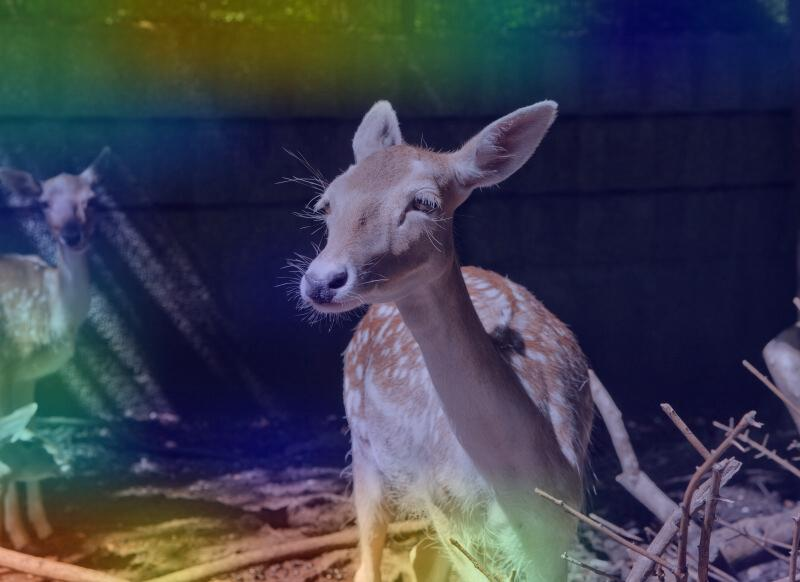

In [20]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

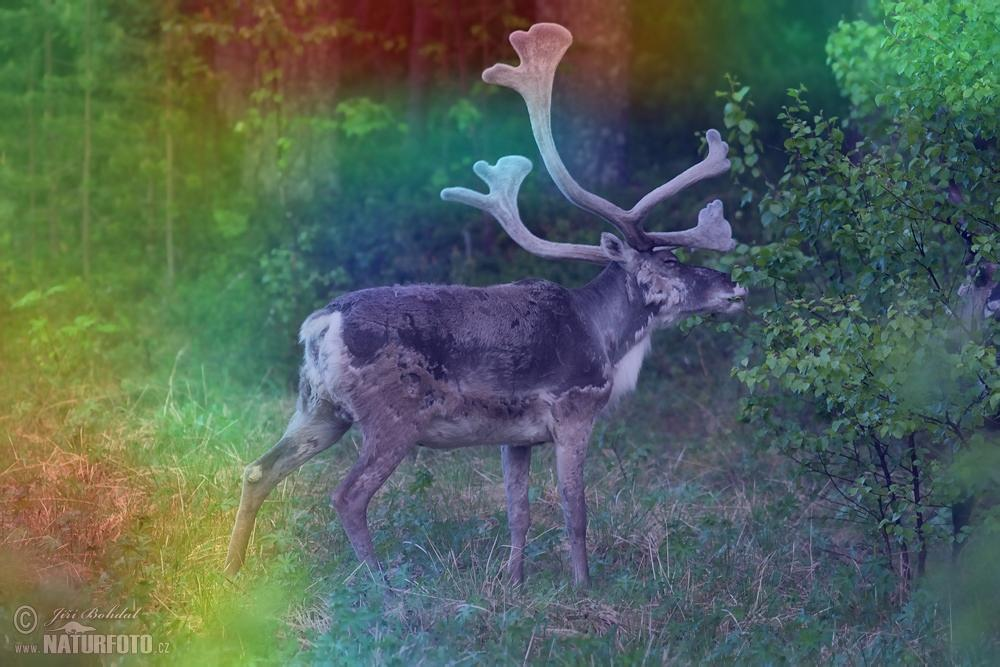

In [21]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou56.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

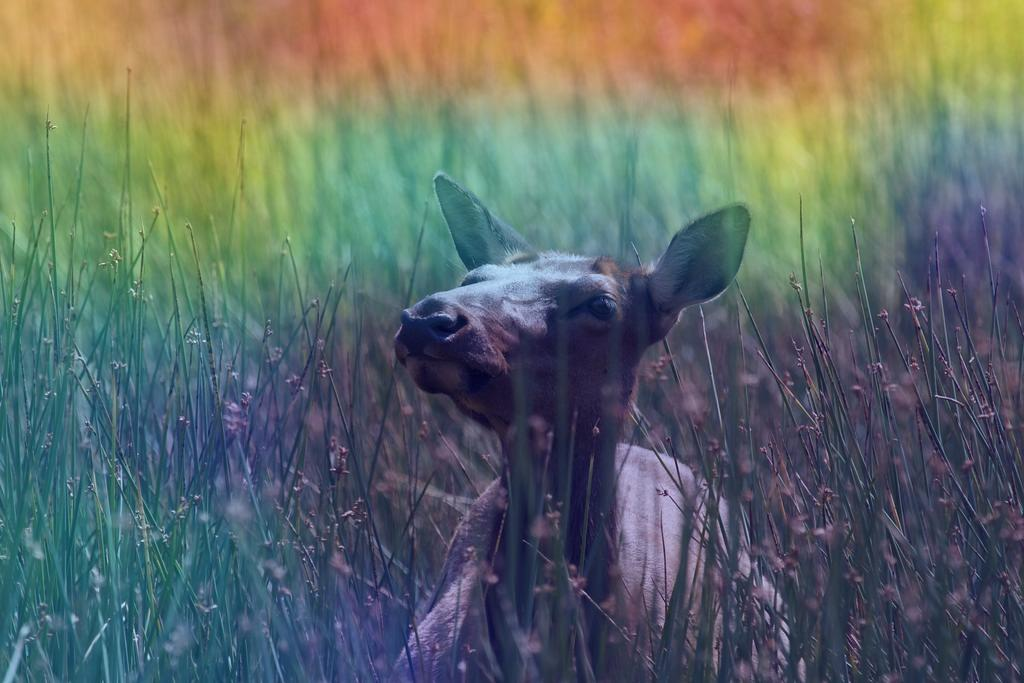

In [22]:
grad_cam_img_path = 'dataset/train/elk/EDF9.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

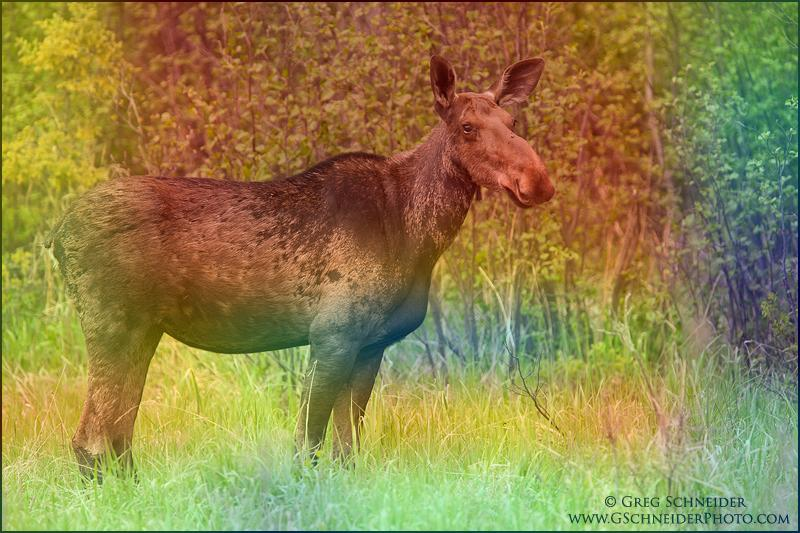

In [23]:

grad_cam_img_path = 'dataset/train/moose/female_moose (23).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

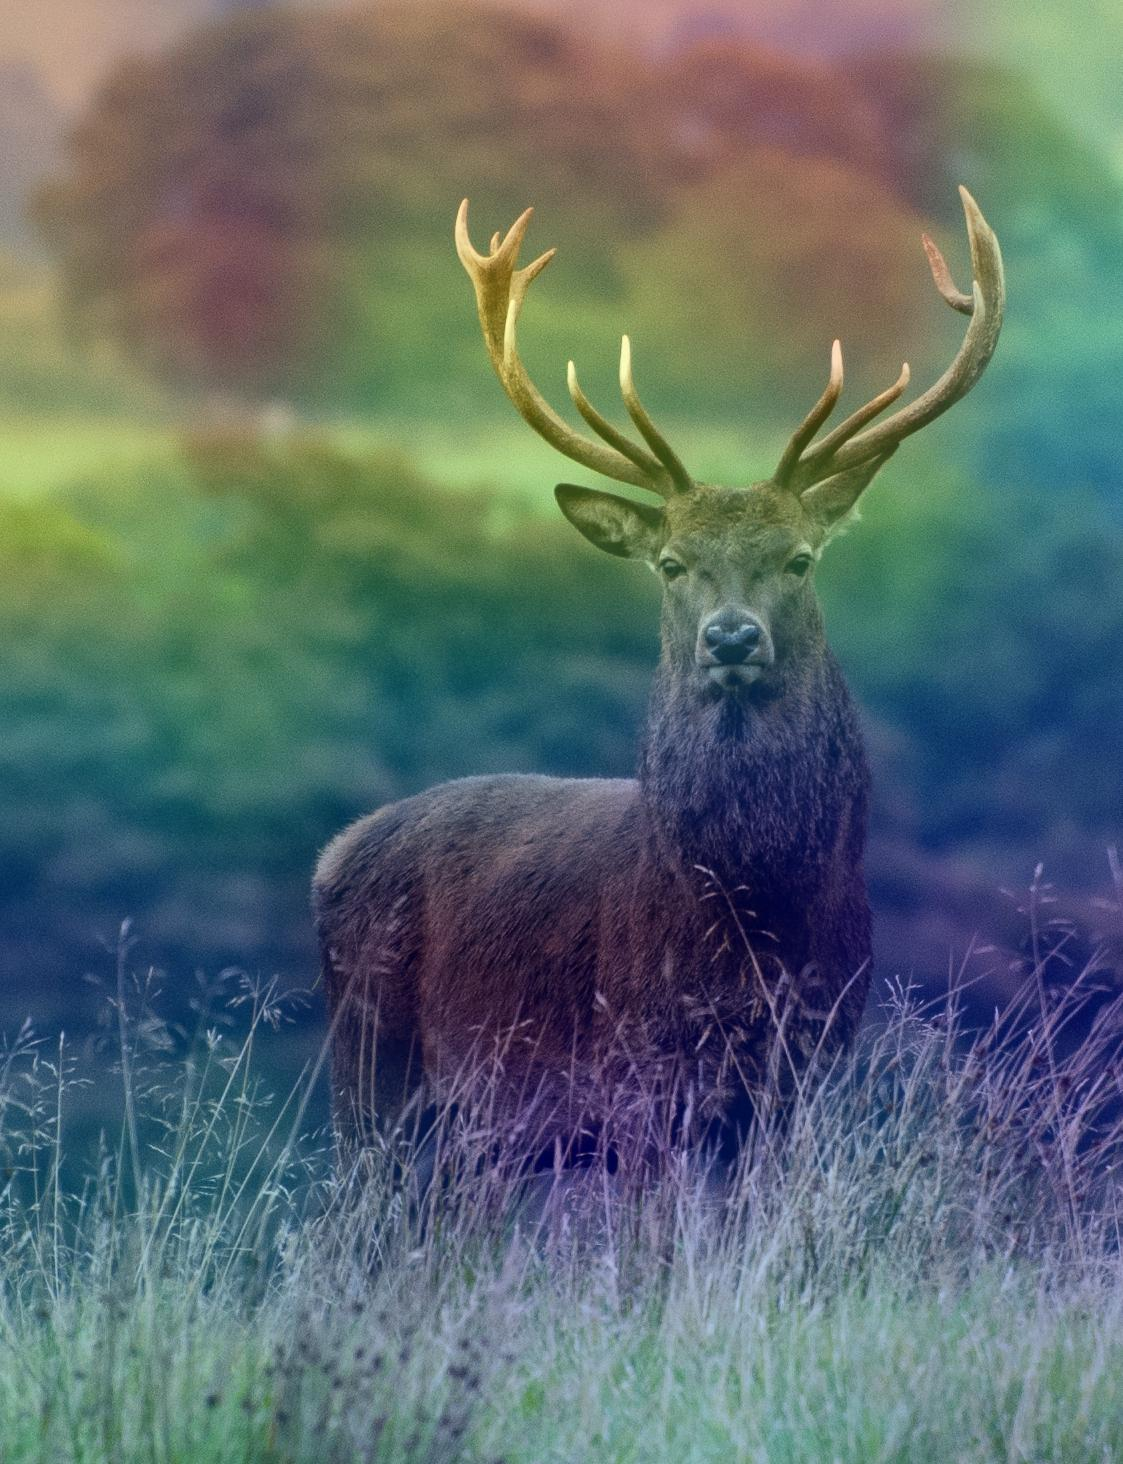

In [24]:
grad_cam_img_path = 'dataset/test/deer/red_deer_00044.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

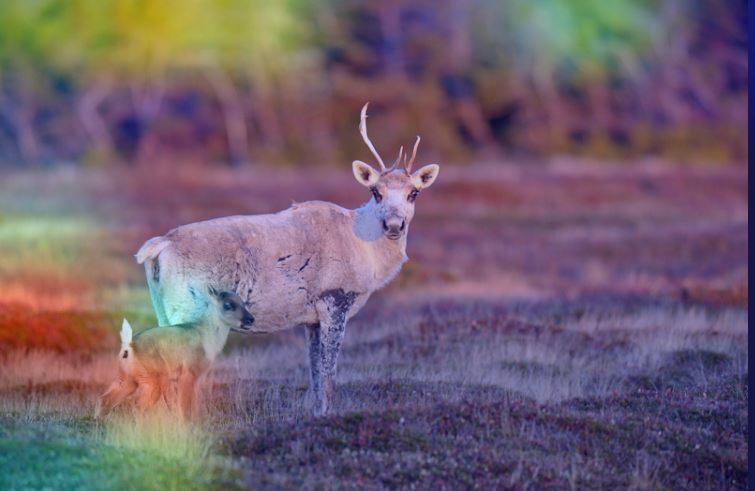

In [25]:
grad_cam_img_path = 'dataset/train/caribou/Female_Caribou91.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

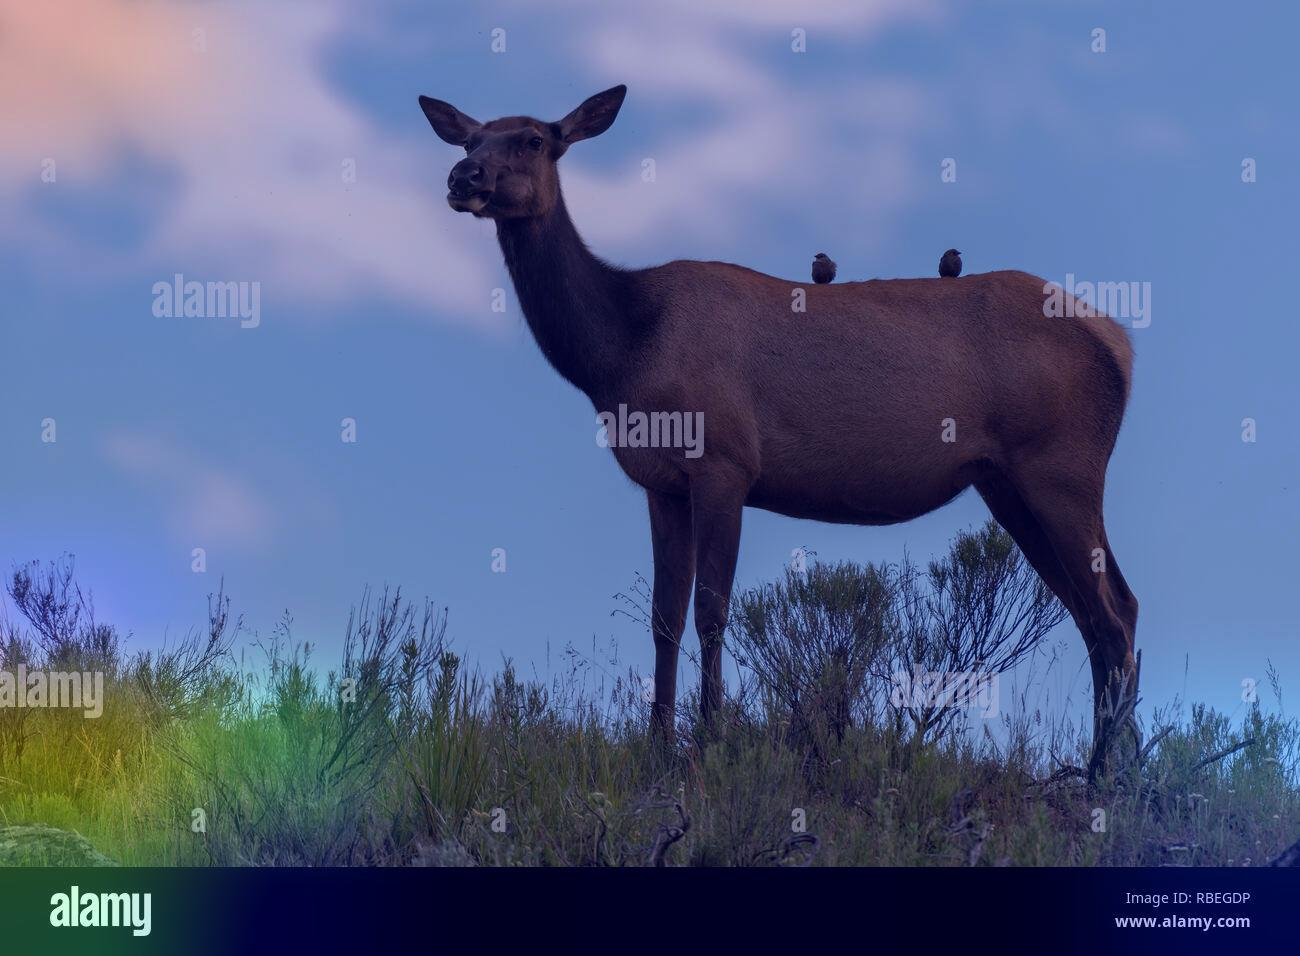

In [26]:
grad_cam_img_path = 'dataset/train/elk/EDF78.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

2023-11-04 13:26:03.293020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 25s 25s/step


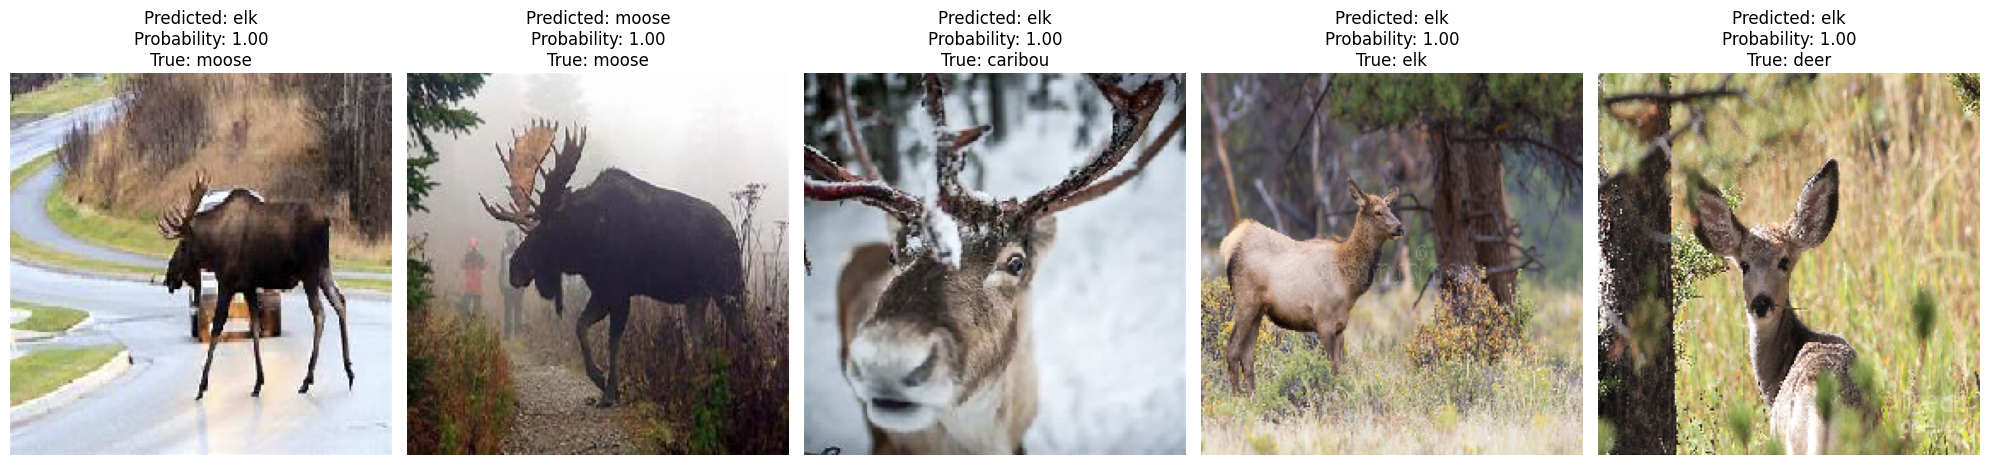

In [27]:
test_images_directory = 'dataset/test/'
class_name = {0:'caribou',1:'deer',2:'elk',3:'moose'}
show_predicted_img(loaded_model,test_images_directory,class_name)

In [28]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image, label in test_dataset:
   # append true labels
   y_true.append(label)
   # compute predictions
   preds = loaded_model.predict(image)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 158ms/step


Text(0.5, 1.0, 'ResNet152V2')

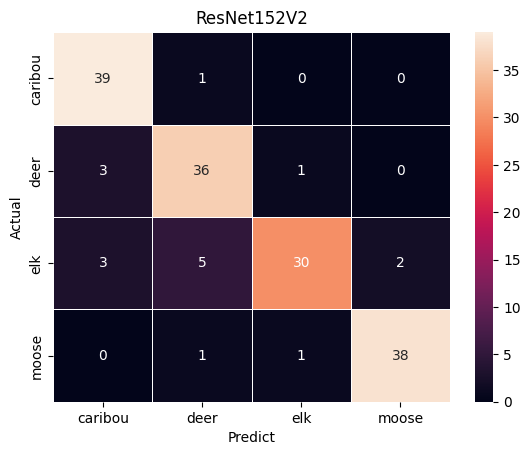

In [29]:
label = ['caribou','deer','elk','moose']
cm = confusion_matrix(correct_labels, predicted_labels)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')
plt.title('ResNet152V2')

Text(0.5, 1.0, 'ResNet152V2')

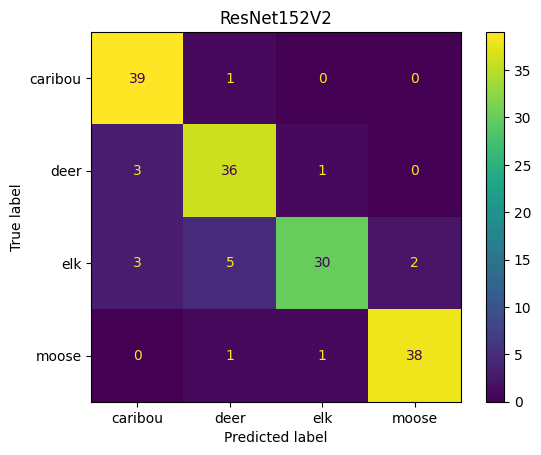

In [30]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels,display_labels=label)
plt.title("ResNet152V2")

In [31]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        40
           1       0.84      0.90      0.87        40
           2       0.94      0.75      0.83        40
           3       0.95      0.95      0.95        40

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160



# Evaluate performance by re-initialize weight of fc layers and fit again

In [32]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch63_nopool_valloss0.29.h5"
load_resnet_trained = tf.keras.models.load_model(model_path)
load_resnet_trained.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [33]:
stop_train = 564
for layer in load_resnet_trained.layers[:stop_train]:
  layer.trainable = False

for i,layer in enumerate(load_resnet_trained.layers):
    if layer.trainable == True:
      print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 564: name = flatten_6 , trainable = True
Layer 565: name = dense_28 , trainable = True
Layer 566: name = batch_normalization_22 , trainable = True
Layer 567: name = dense_29 , trainable = True
Layer 568: name = batch_normalization_23 , trainable = True
Layer 569: name = dense_30 , trainable = True
Layer 570: name = batch_normalization_24 , trainable = True
Layer 571: name = dropout_6 , trainable = True
Layer 572: name = dense_31 , trainable = True


In [34]:
for layer in load_resnet_trained.layers[stop_train:]:
    initializer = tf.keras.initializers.RandomNormal()
    layer.set_weights([initializer(shape=w.shape) for w in layer.get_weights()])

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [35]:
load_resnet_trained.get_layer(index=567).get_weights()

[array([[-0.06640575, -0.00627151,  0.00860374, ..., -0.07355577,
         -0.047033  ,  0.01000007],
        [-0.01046419,  0.05225166,  0.09408669, ..., -0.04277503,
         -0.01504105,  0.04787203],
        [ 0.04132535, -0.03166634,  0.00800613, ...,  0.0050238 ,
         -0.09048565, -0.00148536],
        ...,
        [-0.04021076,  0.07765888,  0.03461217, ..., -0.04754728,
          0.05967628,  0.01253007],
        [-0.04525909,  0.02379933, -0.05580087, ...,  0.04267673,
          0.00049835, -0.04083151],
        [ 0.01796938,  0.05624947, -0.04545029, ...,  0.04426682,
         -0.006769  , -0.00632238]], dtype=float32),
 array([-6.64057508e-02, -6.27151458e-03,  8.60374235e-03,  5.72434925e-02,
        -1.97652206e-02, -2.25692578e-02, -5.68318181e-02, -8.19692090e-02,
        -4.71373089e-02,  1.84690338e-02, -4.08090167e-02, -1.93126015e-02,
        -3.95992883e-02, -9.13706236e-03,  1.34006953e-02, -3.15966271e-02,
         3.80826332e-02,  4.66229506e-02,  7.28857657e

In [36]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

load_resnet_trained.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [37]:
epoch = 30
model_history=load_resnet_trained.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs = epoch,
                        verbose = 2)

Epoch 1/30


2023-11-04 13:27:11.319552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-04 13:27:50.701584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-04 13:28:06.563853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 90s - loss: 1.3768 - accuracy: 0.2969 - val_loss: nan - val_accuracy: 0.2812 - 90s/epoch - 2s/step
Epoch 2/30


2023-11-04 13:28:42.470282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 1.3380 - accuracy: 0.5278 - val_loss: nan - val_accuracy: 0.2812 - 20s/epoch - 562ms/step
Epoch 3/30


2023-11-04 13:29:03.075761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 1.3057 - accuracy: 0.6102 - val_loss: nan - val_accuracy: 0.2812 - 21s/epoch - 576ms/step
Epoch 4/30


2023-11-04 13:29:23.097158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 1.2600 - accuracy: 0.6832 - val_loss: nan - val_accuracy: 0.2812 - 21s/epoch - 575ms/step
Epoch 5/30


2023-11-04 13:29:44.034968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 1.2094 - accuracy: 0.7257 - val_loss: nan - val_accuracy: 0.2812 - 20s/epoch - 559ms/step
Epoch 6/30


2023-11-04 13:30:04.589526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 1.1547 - accuracy: 0.7318 - val_loss: nan - val_accuracy: 0.2812 - 21s/epoch - 572ms/step
Epoch 7/30


2023-11-04 13:30:24.592263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 1.1005 - accuracy: 0.7370 - val_loss: nan - val_accuracy: 0.2812 - 20s/epoch - 562ms/step
Epoch 8/30


2023-11-04 13:30:44.909386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 1.0396 - accuracy: 0.7552 - val_loss: nan - val_accuracy: 0.2812 - 20s/epoch - 553ms/step
Epoch 9/30


2023-11-04 13:31:04.800705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.9987 - accuracy: 0.7604 - val_loss: 0.5472 - val_accuracy: 0.8906 - 20s/epoch - 550ms/step
Epoch 10/30


2023-11-04 13:31:24.506086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.9393 - accuracy: 0.7908 - val_loss: 0.5218 - val_accuracy: 0.8750 - 20s/epoch - 561ms/step
Epoch 11/30


2023-11-04 13:31:44.850445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.9066 - accuracy: 0.7639 - val_loss: 0.5051 - val_accuracy: 0.8750 - 20s/epoch - 551ms/step
Epoch 12/30


2023-11-04 13:32:04.649225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.8506 - accuracy: 0.7812 - val_loss: 0.4841 - val_accuracy: 0.8906 - 20s/epoch - 558ms/step
Epoch 13/30


2023-11-04 13:32:24.703023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.8325 - accuracy: 0.7726 - val_loss: 0.4686 - val_accuracy: 0.8750 - 20s/epoch - 564ms/step
Epoch 14/30


2023-11-04 13:32:45.609676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 0.7986 - accuracy: 0.7630 - val_loss: 0.4557 - val_accuracy: 0.8750 - 21s/epoch - 587ms/step
Epoch 15/30


2023-11-04 13:33:06.487559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.7591 - accuracy: 0.7908 - val_loss: 0.4447 - val_accuracy: 0.8906 - 20s/epoch - 563ms/step
Epoch 16/30


2023-11-04 13:33:26.404740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.7241 - accuracy: 0.7934 - val_loss: 0.4265 - val_accuracy: 0.8906 - 20s/epoch - 556ms/step
Epoch 17/30


2023-11-04 13:33:46.474898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 0.7047 - accuracy: 0.7925 - val_loss: 0.4134 - val_accuracy: 0.8750 - 21s/epoch - 572ms/step
Epoch 18/30


2023-11-04 13:34:07.239795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.6724 - accuracy: 0.7943 - val_loss: 0.4048 - val_accuracy: 0.8906 - 20s/epoch - 558ms/step
Epoch 19/30


2023-11-04 13:34:27.448541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 21s - loss: 0.6622 - accuracy: 0.7986 - val_loss: 0.3985 - val_accuracy: 0.8750 - 21s/epoch - 574ms/step
Epoch 20/30


2023-11-04 13:34:48.037420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.6434 - accuracy: 0.7917 - val_loss: 0.3899 - val_accuracy: 0.8750 - 20s/epoch - 563ms/step
Epoch 21/30


2023-11-04 13:35:08.197029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.6305 - accuracy: 0.7856 - val_loss: 0.3885 - val_accuracy: 0.8906 - 20s/epoch - 558ms/step
Epoch 22/30


2023-11-04 13:35:28.449075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.6289 - accuracy: 0.7856 - val_loss: 0.3742 - val_accuracy: 0.8906 - 20s/epoch - 555ms/step
Epoch 23/30


2023-11-04 13:35:48.197192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5979 - accuracy: 0.7969 - val_loss: 0.3629 - val_accuracy: 0.8906 - 20s/epoch - 550ms/step
Epoch 24/30


2023-11-04 13:36:08.136786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5906 - accuracy: 0.7969 - val_loss: 0.3660 - val_accuracy: 0.8906 - 20s/epoch - 560ms/step
Epoch 25/30


2023-11-04 13:36:28.269125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5793 - accuracy: 0.8073 - val_loss: 0.3621 - val_accuracy: 0.8750 - 20s/epoch - 553ms/step
Epoch 26/30


2023-11-04 13:36:48.304052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5875 - accuracy: 0.7951 - val_loss: 0.3605 - val_accuracy: 0.9062 - 20s/epoch - 549ms/step
Epoch 27/30


2023-11-04 13:37:08.015903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5585 - accuracy: 0.8116 - val_loss: 0.3634 - val_accuracy: 0.8906 - 20s/epoch - 547ms/step
Epoch 28/30


2023-11-04 13:37:27.568672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5483 - accuracy: 0.8073 - val_loss: 0.3502 - val_accuracy: 0.8906 - 20s/epoch - 542ms/step
Epoch 29/30


2023-11-04 13:37:47.184544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5453 - accuracy: 0.8108 - val_loss: 0.3454 - val_accuracy: 0.9062 - 20s/epoch - 544ms/step
Epoch 30/30


2023-11-04 13:38:06.928340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 - 20s - loss: 0.5711 - accuracy: 0.7934 - val_loss: 0.3399 - val_accuracy: 0.8906 - 20s/epoch - 552ms/step


In [38]:
test_result = load_resnet_trained.evaluate(test_dataset)
print(f'{load_resnet_trained.metrics_names}: {test_result}')

5/5 [==============================] - 3s 342ms/step - loss: 0.2809 - accuracy: 0.9187
['loss', 'accuracy']: [0.28091102838516235, 0.918749988079071]


2023-11-04 13:38:26.214390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 159ms/step


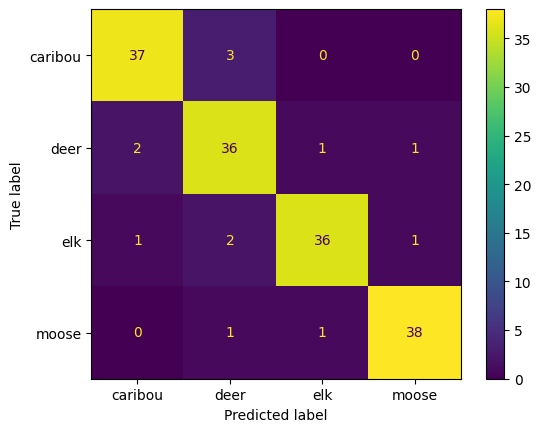

In [39]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image, label in test_dataset:
   # append true labels
   y_true.append(label)
   # compute predictions
   preds = load_resnet_trained.predict(image)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
label = test_ds.class_names
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels,display_labels=label)